# Decay of $\Lambda_c$: Rescattering effects

In [1]:
const m1 = 0.938;   const m1sq = m1^2;
const m2 = 0.13957; const m2sq = m2^2;
const m3 = 0.49367; const m3sq = m3^2;
const m0 = 2.2845;  const m0sq = m0^2;

In [2]:
using Plots

In [3]:
λ(x,y,z) = x^2+y^2+z^2-2x*y-2y*z-2z*x
# sigma1(y) as a function of sigma2
# sigma1 = (p0-p1)^2
σ1b(σ2) = m1sq+m0sq-(m0sq+σ2-m2sq)*(σ2+m1sq-m3sq)/(2σ2) .+ sqrt(λ(m0sq,σ2,m2sq)*λ(σ2,m1sq,m3sq))/(2σ2) .* [-1,1]
Kibble(σ1,σ2) = (2σ2*(m1sq+m0sq-σ1)-(m0sq+σ2-m2sq)*(σ2+m1sq-m3sq))^2 - λ(m0sq,σ2,m2sq)*λ(σ2,m1sq,m3sq)
inBorder(σ1,σ2) = Kibble(σ1,σ2) < 0.0 ? 1.0 : NaN

inBorder (generic function with 1 method)

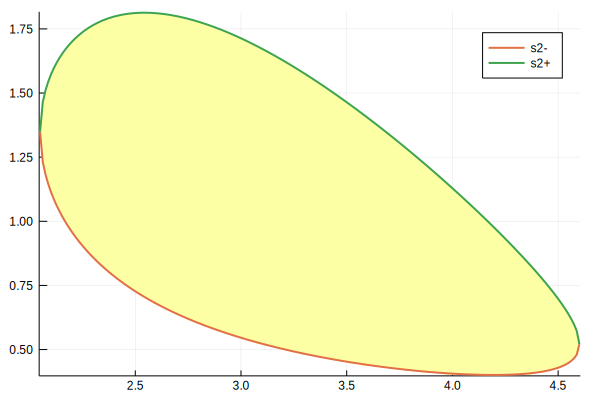

In [4]:
let σ2v = linspace((m3+m1)^2, (m0-m2)^2, 300), σ1v = linspace((m2+m3)^2, (m0-m1)^2, 200),
    cal = [inBorder(σ1,σ2) for σ1 in σ1v, σ2 in σ2v]
    heatmap(σ2v, σ1v, cal, lab="", colorbar=false)
end
let σ2v = linspace((m3+m1)^2, (m0-m2)^2, 200)
    σ1v = hcat(σ1b.(σ2v)...)'
    plot!(σ2v, σ1v, lab=["s2-" "s2+"], lw=2)
end

### Dynamics of the reaction

In [5]:
const mKs = 0.89176; const ΓKs = 0.05;
const mΛ  = 1.5195;  const ΓΛ  = 0.0156;
const mΔ  = 1.232;   const ΓΔ = 0.112;

In [6]:
BW(σ,msq,Γ) = 1.0 / (msq-σ-1im*√msq*Γ)
######
Ks(σ) = BW(σ,mKs^2,ΓKs)
Λ(σ) = BW(σ,mΛ^2,ΓΛ)
Δ(σ) = BW(σ,mΔ^2,ΓΔ)

Csl = [
    # channel #1 pi K
    [(Ks, 1.0)],
    # channel #2 K p
    [(Λ, 1.0)],
    # channel #3 p pi
    [(Δ, 3.0)]
]

3-element Array{Array{Tuple{Function,Float64},1},1}:
 Tuple{Function,Float64}[(Ks, 1.0)]
 Tuple{Function,Float64}[(Λ, 1.0)] 
 Tuple{Function,Float64}[(Δ, 3.0)] 

### Matrix element and Intensity

In [7]:
function M(σ1,σ2, Csl)
    σs = [σ1, σ2, m0sq+m1sq+m2sq+m3sq-σ1-σ2]
    sum(sum(R(σs[k])*c for (R,c) in Csl[k]) for k = 1:3)
end
intens(pars...) = abs2(M(pars...))

intens (generic function with 1 method)

### Preparing unitarity form of Breit-Wigner function 

In [8]:
using QuadGK

In [9]:
function ChewMandelstam(x,m1sq,m2sq)
    m1 = sqrt(m1sq); m2 = sqrt(m2sq)
    #
    first_log_terms = 
        -1/x*sqrt((m1 + m2)^2 - x)*sqrt((m1 - m2)^2 - x) *
            log(
                (sqrt((m1+m2)^2 - x) +  sqrt((m1-m2)^2 - x)) /
                    (2.0*sqrt(m1*m2))
            ) +
        (m1sq - m2sq)/(4*x)*log(m1sq/m2sq)
    #
    last_term = (m1 == m2) ? 1/m2sq : (log(m1sq) - log(m2sq))/(m1sq - m2sq)
    #
    res = first_log_terms - (m1sq + m2sq)/4.0*last_term - 0.5
    return (-2.0)/π*res
end

ChewMandelstam (generic function with 1 method)

In [10]:
function CM(s)
    ChewMandelstam(s,m1sq,m2sq)
end

CM (generic function with 1 method)

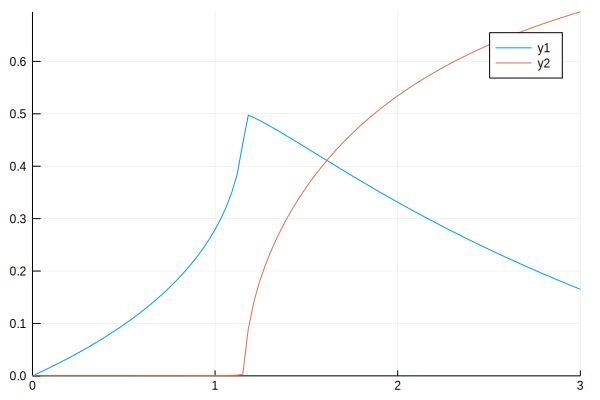

In [11]:
let sv = linspace(0,3,100)
    cal = CM.(sv.+1e-3im)
    plot(sv,[real.(cal) imag.(cal)])
end

In [12]:
@time for i=1:10000
    CM.(rand()+1e-6im)
end

  0.005469 seconds


Check it integrals are the same

In [13]:
function Δproper(σ)
    m = mΔ;
    const CM0 = CM(mΔ^2+1e-5im)
    const rCM0 = real(CM0)
    const iCM0 = imag(CM0)
    const g = mΔ*ΓΔ/iCM0
    1/(m^2-σ-g*(CM(σ)-rCM0))
end

Δproper (generic function with 1 method)

In [14]:
# check disconitnuity
@show Δproper((m2+m3)^2-0.01+1e-5im)-Δproper((m2+m3)^2-0.01-1e-5im)
# check that zero is finite
@show Δproper(1e-5im)

Δproper(((m2 + m3) ^ 2 - 0.01) + 1.0e-5im) - Δproper(((m2 + m3) ^ 2 - 0.01) - 1.0e-5im) = 0.0 + 1.3599231556066703e-5im
Δproper(1.0e-5im) = 0.5955369291243193 + 3.7596976070687957e-6im


0.5955369291243193 + 3.7596976070687957e-6im

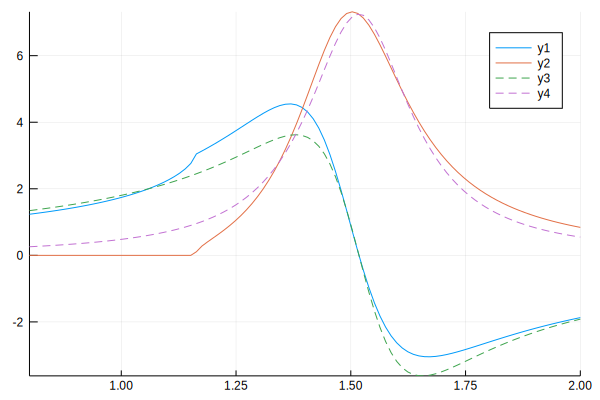

In [15]:
let sv = linspace(0.8,2,100)
    cal = Δproper.(sv.+1e-5im)
    plot(sv,[real.(cal) imag.(cal)])
    cal = Δ.(sv)
    plot!(sv,[real.(cal) imag.(cal)], ls=:dash)
end

## Projection of $\Delta^{++}$ to $K\pi$ channel

In [16]:
function σ3proper(σ1)
    s = m0sq+1e-3im
    sqrtλλ = sqrt(σ1-(m3+m2)^2)*sqrt(σ1-(m3-m2)^2)*sqrt((√s-m1)^2-σ1)*sqrt((√s+m1)^2-σ1)
    m3sq+s-(s+σ1-m1sq)*(σ1+m3sq-m2sq)/(2σ1) .+ sqrtλλ/(2σ1) .* [-1,1]
end
σ1_of_3(σ3) = m1sq+m0sq-(m0sq+σ3-m3sq)*(σ3+m1sq-m2sq)/(2σ3) .+ sqrt(λ(m0sq,σ3,m3sq)*λ(σ3,m1sq,m2sq))/(2σ3) .* [-1,1]

σ1_of_3 (generic function with 1 method)

#### Projection itself

In [17]:
ampproj1(σ1)       = quadgk(σ3->Δproper(σ3),σ3proper(σ1)...)[1]
ampproj1proper(σ1) = quadgk(σ3->Δproper(σ3), σ3proper(σ1)[1], 1e-5)[1]+
                     quadgk(σ3->Δproper(σ3), 1e-5, σ3proper(σ1)[2])[1]

ampproj1proper (generic function with 1 method)

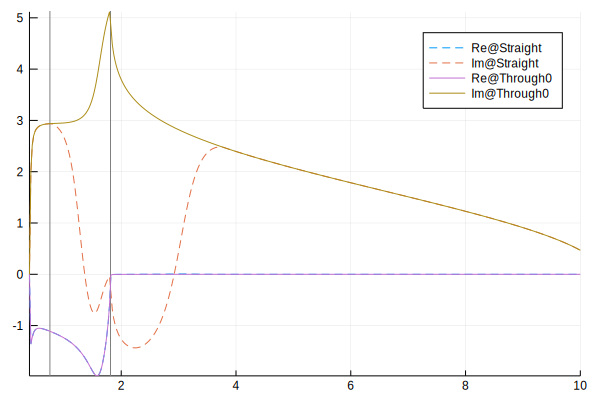

In [18]:
let σv=linspace((m2+m3)^2,10,400)
    cal = ampproj1.(σv)
    plot(σv,[real.(cal) imag.(cal)], ls=:dash, lab=["Re@Straight" "Im@Straight"])
    vline!([(m0-m1)^2, σ1_of_3((m1+m2)^2)[2]], lab="", l=(:grey))
    cal = ampproj1proper.(σv)
    plot!(σv,[real.(cal) imag.(cal)], lab=["Re@Through0" "Im@Through0"])
end

## Last dispersive integral

In [19]:
function triangle(σ1)
    const s = m0sq+1e-3im
    function integrand(x)
        ampproj1proper(x)/(x-σ1-1e-3im)/(sqrt((√s-m1)^2-x)*sqrt((√s+m1)^2-x))
    end
    quadgk(integrand, (m2+m3)^2, Inf)[1]
end

triangle (generic function with 1 method)

In [20]:
Tr13 = let σ1v=linspace((m2+m3)^2,(m0-m1)^2,30)
    triangle.(σ1v)
end;

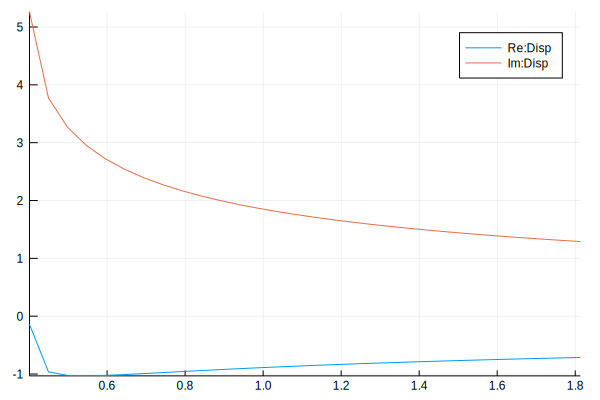

In [21]:
let σ1v=linspace((m2+m3)^2,(m0-m1)^2,30)
    cal = Tr13
    plot(σ1v,[real.(cal) imag.(cal)], lab = ["Re:Disp" "Im:Disp"])
end

## Feynman triangle

In [22]:
function IscIntegrand(x, m1sq, m2sq, m3sq, M1sq, M2sq, M3sq)
    Ay = M1sq;
    By = m2sq + x*M2sq - (1-x)*M1sq - x*M3sq-m3sq;
    Cy = x*m1sq + (1-x)*m3sq - x*(1-x)*M2sq;
    Dy = By^2-4*Ay*Cy;
    y1, y2 = (-By-sqrt(Dy)*[1.0, -1.0])/(2*Ay);
    return (log((1-x-y2)/(-y2))-log((1-x-y1)/(-y1)))/(Ay*(y2-y1))
end

function Isc(m1sq, m2sq, m3sq, M1sq, M2sq, M3sq)
    integr = quadgk(x->IscIntegrand(x, m1sq, m2sq, m3sq, M1sq, M2sq, M3sq), 0, 1)[1];
    return integr;
end

Isc (generic function with 1 method)

In [23]:
production(σ1) = Isc(mΔ^2-1im*mΔ*ΓΔ, m3sq, m2sq, σ1, m1sq, m0sq)

production (generic function with 1 method)

## Comparison

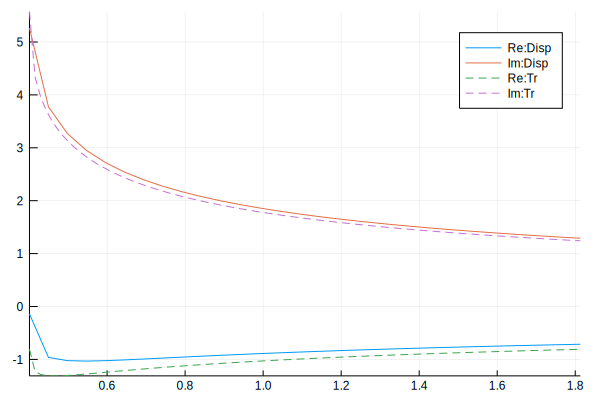

In [24]:
let σ1v=linspace((m2+m3)^2,(m0-m1)^2,100)
    cal = production.(σ1v)
    plot!(σ1v, [real.(cal) imag.(cal)], lab = ["Re:Tr" "Im:Tr"], ls=:dash)
end

### Comparison normal $K^*$ with rescattered $K^*$

In [25]:
argπ2(z,ϕ=2π/3) = atan2(imag(z*cis(-ϕ)), real(z*cis(-ϕ)))+ϕ
arg(z) = atan2(imag(z), real(z))

arg (generic function with 1 method)

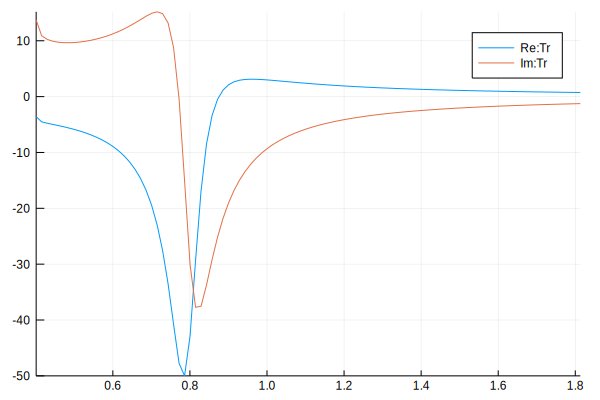

In [26]:
let σ1v=linspace((m2+m3)^2,(m0-m1)^2,100)
    cal = [Ks(x)*production(x) for x in σ1v]
    plot(σ1v, [real.(cal) imag.(cal)], lab = ["Re:Tr" "Im:Tr"])
end

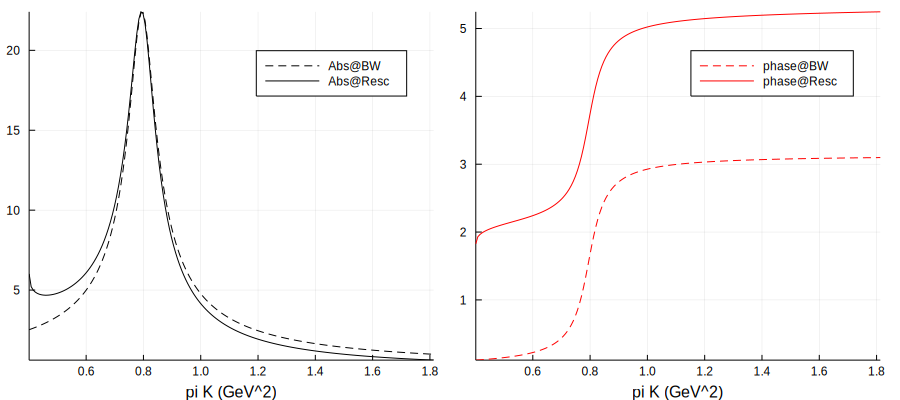

In [28]:
let σ1v=linspace((m2+m3)^2,(m0-m1)^2,200)
    plot(layout=grid(1,2), size=(900,400), xlab="pi K (GeV^2)")
    cal = [Ks(x) for x in σ1v]
    plot!(σ1v, abs.(cal), lab = "Abs@BW", l=(:black,:dash), subplot=1)
    cal = [Ks(x) for x in σ1v]
    plot!(σ1v, arg.(cal), lab = "phase@BW", l=(:red,:dash), subplot=2)
###################
    sc = 1/abs(production(mKs^2))
    cal = [Ks(x)*production(x)*sc for x in σ1v]
    plot!(σ1v, abs.(cal), lab = "Abs@Resc", l=(:black), subplot=1)
    cal = [Ks(x)*production(x)*sc for x in σ1v]
    plot!(σ1v, argπ2.(cal,2.2), lab = "phase@Resc", l=(:red), subplot=2)
end

In [272]:
savefig("Ks.pdf")